In [1]:
import scanpy as sc
from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
import scvelo as scv
import numpy as np
from pandas import DataFrame
import cloudpickle

import jax.numpy as jnp

from typing import List, Tuple

In [2]:
with open(f'/home/icb/jonas.flor/gastrulation_atlas/scvi/reference_query/divergences/flow/1M/10k_genes/2/2048/integrated_cond_model.pt', mode='rb') as file:
       fm = cloudpickle.load(file)

In [11]:
gast = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/reference_query/scarches/1M/10k_genes/2/2048/gastrulation/gastrulation_adata.h5ad')
gast

AnnData object with n_obs × n_vars = 89267 × 10000
    obs: 'day', 'celltype'
    uns: 'log1p', 'pca'
    obsm: 'X_emb', 'X_pca'
    varm: 'PCs'

In [12]:
gast[[x in [8.25, 8.5] for x in gast.obs.day]]

View of AnnData object with n_obs × n_vars = 31403 × 10000
    obs: 'day', 'celltype'
    uns: 'log1p', 'pca'
    obsm: 'X_emb', 'X_pca'
    varm: 'PCs'

In [3]:
adata = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/reference_query/scarches/flow/cond_adata_exvito_10k_genes_integrated_elbo.h5ad')
adata_sub = sc.pp.subsample(adata, n_obs=10000, copy=True)
adata_sub

/home/icb/jonas.flor/mambaforge/envs/flow_cellrank/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/jonas.flor/mambaforge/envs/flow_cellrank/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10000 × 10000
    obs: 'day', 'celltype', 'datasets'
    uns: 'neighbors', 'umap'
    obsm: 'X_emb', 'X_new', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
adata_new = adata_sub[adata_sub.obs.day==8.5, :50]
adata_new.layers['velocity'] = np.array(fm.transport(jnp.array(adata_sub[adata_sub.obs.day==8.5].obsm['X_new']), 
                               condition=np.expand_dims(adata_sub[adata_sub.obs.day==8.5].obs.day.values, axis=1), 
                               forward=True)
                  )-adata_sub[adata_sub.obs.day==8.5].obsm['X_new']
adata_new.layers['spliced'] = np.ones_like(adata_new.obsm['X_emb'])
adata_new.layers['unspliced'] = np.ones_like(adata_new.obsm['X_emb'])
adata_new.layers['X_emb'] = np.asarray(adata_sub[adata_sub.obs.day==8.5].obsm['X_new'])
adata_new

/tmp/ipykernel_932354/211798486.py:2: ImplicitModificationWarning: Setting element `.layers['velocity']` of view, initializing view as actual.
  adata_new.layers['velocity'] = np.array(fm.transport(jnp.array(adata_sub[adata_sub.obs.day==8.5].obsm['X_new']),


AnnData object with n_obs × n_vars = 4892 × 50
    obs: 'day', 'celltype', 'datasets'
    uns: 'neighbors', 'umap'
    obsm: 'X_emb', 'X_new', 'X_pca', 'X_umap'
    layers: 'velocity', 'spliced', 'unspliced', 'X_emb'
    obsp: 'connectivities', 'distances'

In [5]:
sc.pp.neighbors(adata_new, use_rep='X_emb')
scv.pp.moments(adata_new)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
vk = VelocityKernel(adata_new, attr='layers', xkey="X_emb", vkey="velocity").compute_transition_matrix()
g = GPCCA(vk)

  0%|          | 0/4892 [00:00<?, ?cell/s]

  0%|          | 0/4892 [00:00<?, ?cell/s]

In [7]:
g.compute_schur(n_components=15, method='brandts')

GPCCA[kernel=VelocityKernel[n=4892], initial_states=None, terminal_states=None]

In [8]:
#g.fit(cluster_key="cellcluster_moscot", n_states=30)

In [9]:
g.compute_macrostates(cluster_key='celltype', n_states=15)

GPCCA[kernel=VelocityKernel[n=4892], initial_states=None, terminal_states=None]

In [10]:
g.predict_terminal_states()

GPCCA[kernel=VelocityKernel[n=4892], initial_states=None, terminal_states=['Extra-Embryonic ectoderm_2', 'Mid-Hind Gut_2', 'Mixed_1']]

  0%|          | 0/3 [00:00<?, ?/s]

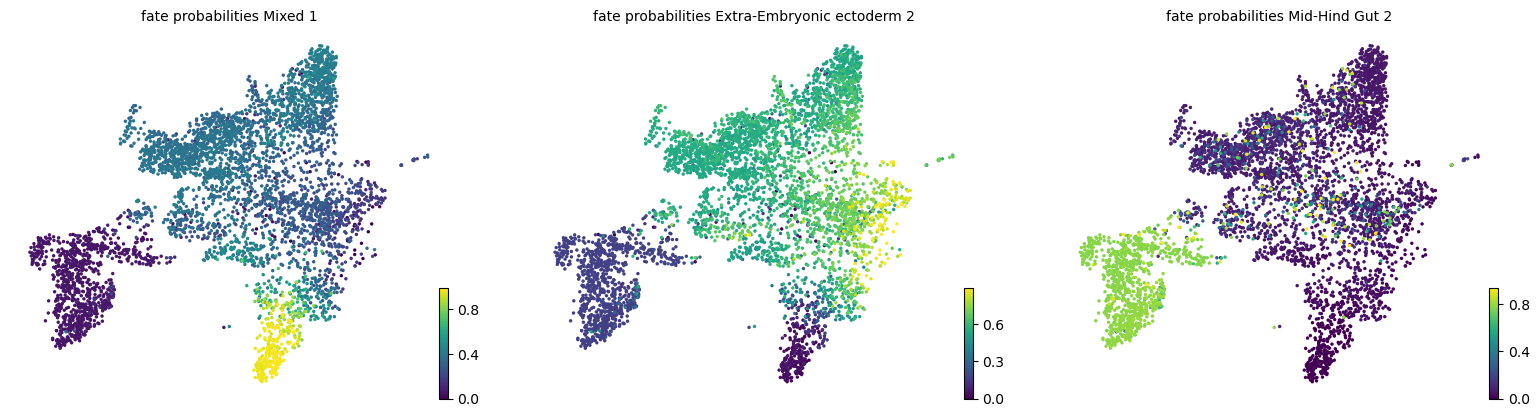

In [11]:
g.compute_fate_probabilities(use_petsc=False)
g.plot_fate_probabilities(same_plot=False)

In [12]:
driver_genes = g.compute_lineage_drivers(cluster_key='cellcluster_moscot')
driver_genes

,Mixed_1_corr,Mixed_1_pval,Mixed_1_qval,Mixed_1_ci_low,Mixed_1_ci_high,Extra-Embryonic ectoderm_2_corr,Extra-Embryonic ectoderm_2_pval,Extra-Embryonic ectoderm_2_qval,Extra-Embryonic ectoderm_2_ci_low,Extra-Embryonic ectoderm_2_ci_high,Mid-Hind Gut_2_corr,Mid-Hind Gut_2_pval,Mid-Hind Gut_2_qval,Mid-Hind Gut_2_ci_low,Mid-Hind Gut_2_ci_high
ENSMUSG00000033845,0.673114,0.000000e+00,0.000000e+00,0.657492,0.688156,0.137820,3.065526e-22,3.193257e-22,0.110222,0.165206,-0.587101,0.000000e+00,0.000000e+00,-0.605168,-0.568430
ENSMUSG00000032719,0.546998,0.000000e+00,0.000000e+00,0.527054,0.566341,-0.036139,1.147246e-02,1.147246e-02,-0.064097,-0.008123,-0.368968,1.914674e-161,6.382248e-161,-0.392928,-0.344506
ENSMUSG00000025921,0.478285,2.731787e-290,4.552978e-289,0.456379,0.499613,0.140041,6.414956e-23,6.824422e-23,0.112459,0.167408,-0.447912,4.401438e-249,2.200719e-248,-0.470036,-0.425226
ENSMUSG00000025903,0.457115,4.421416e-261,5.526770e-260,0.434659,0.479002,0.261055,6.461574e-78,7.513458e-78,0.234748,0.286979,-0.520948,0.000000e+00,0.000000e+00,-0.541073,-0.500227
ENSMUSG00000025917,0.365184,7.285693e-158,7.285693e-157,0.340646,0.389224,0.290294,5.510601e-97,6.888252e-97,0.264422,0.315749,-0.475844,8.383125e-287,5.987946e-286,-0.497237,-0.453873
ENSMUSG00000025911,0.343084,5.703636e-138,4.753030e-137,0.318119,0.367574,0.304156,6.676381e-107,9.537687e-107,0.278506,0.329372,-0.469994,1.416338e-278,8.852114e-278,-0.491543,-0.447869
ENSMUSG00000043760,0.323710,6.752706e-122,4.823362e-121,0.298393,0.348571,0.166367,7.782680e-32,8.647422e-32,0.138992,0.193489,-0.355409,7.458600e-149,2.071833e-148,-0.379651,-0.330679
ENSMUSG00000025900,0.303740,1.351019e-106,8.443868e-106,0.278083,0.328964,0.164333,4.342387e-31,4.719986e-31,0.136940,0.191475,-0.339490,6.790983e-135,1.787101e-134,-0.364050,-0.314458
ENSMUSG00000041779,0.266243,4.024000e-81,2.235556e-80,0.240010,0.292087,0.509827,0.000000e+00,0.000000e+00,0.488786,0.530274,-0.564593,0.000000e+00,0.000000e+00,-0.583387,-0.545196
ENSMUSG00000025930,0.201200,3.734505e-46,1.556044e-45,0.174158,0.227938,0.455313,1.064842e-258,3.803006e-258,0.432812,0.477247,-0.477789,1.405181e-289,1.170984e-288,-0.499130,-0.455869


In [11]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20)
scv.pl.velocity_embedding_stream(adata, basis="umap", color="cellcluster_moscot", title="", smooth=0.5, legend_fontsize=2, 
                                 #dpi=500
                                )

NameError: name 'scv' is not defined

In [50]:
def macrostate_computation(g: GPCCA, terminal_states: List[str], steplength: int = 5) -> Tuple[List[str], int, int]:
    """
    Method for computing the minimal number of macrostates such that all terminal states are contained in the
    macrostates. Furthermore, a list with the real terminal state names according to the GPCCA-model is created.

    :param g: GPCCA model
    :param terminal_states: List of terminal states that g should contain
    :param steplength: length of the step when searching for the minimal number of macrostates
    :return: Terminal states of the model, the total number of terminal states and the required number of macrostates
    """
    n_term_states, i_macro_states = terminal_state_search(g, terminal_states=terminal_states, steplength=steplength)

    terminal_states_model = []
    for macro_state in g.terminal_states.cat.categories.astype('string'):
        for state in terminal_states:
            if macro_state.startswith(state):
                terminal_states_model.append(macro_state)
                break

    return terminal_states_model, n_term_states, i_macro_states


def terminal_state_search(g: GPCCA, terminal_states: List[str], steplength: int) -> Tuple[int, int]:
    """
    Computation of the minimal number of macrostates such that given terminal states are contained in the GPCCA model.
    :param g: GPCCA model
    :param terminal_states: List of required terminal states in the GPCCA model
    :param steplength: step size in which the number of macrostates are elevated
    :return: total number of terminal states n and the required number of macrostates i
    """
    i = len(terminal_states)
    contains = False

    # incrementation of the number of macrostates by steplength until all terminal states are detected
    while not contains:
        try:
            contains, _, _ = step(g, terminal_states, i)
            if contains:
                break
            i += steplength
        except ValueError:
            contains = False
            print('Computation of ' + str(i) + ' macrostates not possible. Trying ' + str(i + 1) + ' states')
            i += 1

    up = i
    down = i - steplength
    step_new = steplength
    n_term_states_up = None
    i_macro_states_up = None

    # Search for the minimal number of required macrostates by doing binary search the interval [down, up]
    while up - down > 1:
        step_new = max(step_new // 2, 1)
        while down + step_new >= up:
            step_new = max(step_new // 2, 1)
        try:
            contains, n_term_states, i_macro_states = step(g, terminal_states, down + step_new)
            if contains:
                up = down + step_new
                n_term_states_up = n_term_states
                i_macro_states_up = i_macro_states
            else:
                down = down + step_new
        except ValueError:
            down += 1

    g.compute_macrostates(n_states=i_macro_states_up, cluster_key="celltype")
    g.predict(n_states=n_term_states_up, method='top_n')

    return n_term_states_up, i_macro_states_up


def step(g: GPCCA, terminal_states: List[str], n_states: int) -> Tuple[bool, int, int]:
    """
    Check if given terminal states are contained within n_states macrostates
    :param g: GPCCA model
    :param terminal_states: terminal states. The beginnings of the terminal states must be unique and no name can be
            contained in another
    :param n_states: number of macrostates
    :return: whether the terminal states are contained in the macrostates, the number of used macrostates and the number
            of estimated terminal states with all required terminal states
    """
    g.compute_macrostates(n_states=n_states, cluster_key="celltype")
    n_term_states, i_macro_states, contains = None, None, None
    for n in range(len(terminal_states), n_states + 1):
        g.predict(n_states=n, method='top_n')
        contains = True
        for state in terminal_states:
            # if a state isn't contained in the predicted terminal states, contains will become false
            contains = any([terminal_state.startswith(state) for terminal_state in
                            g.terminal_states.cat.categories.astype('string')])
            # then the number of predicted terminal states must be incremented
            if not contains:
                break
        if contains:  # contains: True, if all terminal states contained in g.terminal_states
            n_term_states = n
            i_macro_states = n_states
            break

    return contains, n_term_states, i_macro_states


def computation_transition_probabilities(g: GPCCA, terminal_states_model: List[str], states: List[str]) -> DataFrame:
    """
    Computation of matrix with values as in cellrank.pl.aggregate_absorption_probabilities
    :param g: GPCCA model
    :param terminal_states_model: terminal states in the model
    :param states: all possible states in the dataset
    :return: Dataframe with aggregated absorption probabilities after terminal states in the model and states in the
            dataset
    """
    import pandas as pd
    import numpy as np

    g.set_terminal_states(terminal_states_model)
    g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')

    terminal_cluster = terminal_states_model

    aggregated_absorption_prob = np.empty((len(terminal_cluster), len(states)))
    data = g.absorption_probabilities.X
    tmp = g.adata.obs['celltype']

    for i in range(len(states)):
        aggregated_absorption_prob[:, i] = np.dot(np.array((tmp.array == states[i]).astype(int)), data)
    for i in range(len(states)):
        aggregated_absorption_prob[:, i] = aggregated_absorption_prob[:, i] / np.sum(aggregated_absorption_prob[:, i])
    df = pd.DataFrame(aggregated_absorption_prob)
    df.index = terminal_cluster
    df.columns = states

    return df


def mean_correct_transition_prob(transition_probabilities: DataFrame, transitions: List[Tuple[str, str]]) -> float:
    """
    :param transition_probabilities: probability of cell fate after model
    :param transitions: correct transitions
    :return: mean of correctly identified transitions
    """
    correct_transitions = []
    for trans in transitions:
        for terminal in transition_probabilities.index:
            if terminal.startswith(trans[1]):
                correct_transitions.append((trans[0], terminal))

    sum_prob = 0
    for i in correct_transitions:
        sum_prob = sum_prob + transition_probabilities.loc[i]
    mean_prob = sum_prob / len(transition_probabilities.columns)

    return mean_prob


In [39]:
vk = VelocityKernel(adata, xkey="X_emb", vkey="velocity").compute_transition_matrix()
g = GPCCA(vk)

  0%|          | 0/24537 [00:00<?, ?cell/s]

  0%|          | 0/24537 [00:00<?, ?cell/s]

In [46]:
liste = adata.obs.cellcluster_moscot.unique()
liste[20:]

['Eye_and_other', 'Intermediate_neuronal_progenitors', 'Lung_and_airways']
Categories (23, object): ['CNS_neurons', 'Cardiocytes', 'Definitive_erythroid', 'Endothelium', ..., 'Olfactory_sensory_neurons', 'Primitive_erythroid', 'Primordial_germ_cells', 'White_blood_cells']

In [51]:
terminal_states =  ['Muscle_cells', 
                    'Epithelial_cells',
                    'CNS_neurons',
                    'Cardiocytes',
                    'Neural_crest_PNS_neurons',
                    'Neural_crest_PNS_glia',
                    'Ependymal_cells',
                    'Intermediate_mesoderm_and_kidney',
                    'White_blood_cells',
                    'Hepatocytes',
                    'Definitive_erythroid',
                    'Olfactory_sensory_neurons',
                    'Gut',
                    'Primordial_germ_cells',
                    'Megakaryocytes', 
                    'Notochord', 
                    'Eye_and_other', 
                    'Intermediate_neuronal_progenitors', 
                    'Lung_and_airways'
                   ]
states = liste.tolist()
transitions = [
    ('Gut', 'Gut'),
    ('Gut', 'Lung_and_airways'),
    ('Gut', 'Hepatocytes'),
    ('Hepatocytes', 'Gut'),
    ('Hepatocytes', 'Hepatocytes'),
    ('Lung_and_airways', 'Lung_and_airways'),
    ('Neural_crest_PNS_neurons', 'Neural_crest_PNS_neurons'),
    ('Neural_crest_PNS_glia', 'Neural_crest_PNS_glia'),
    ('Neural_crest_PNS_glia', 'Olfactory_sensory_neurons'),
    ('Olfactory_sensory_neurons', 'Olfactory_sensory_neurons'),
    ('Notochord', 'Notochord'),
    ('Epithelial_cells', 'Epithelial_cells'),
    ('Neuroectoderm_and_glia', 'Neuroectoderm_and_glia'),
    ('Neuroectoderm_and_glia', 'Eye_and_other'),
    ('Eye_and_other', 'Eye_and_other'),
    ('Eye_and_other', 'CNS_neurons'),
    ('CNS_neurons', 'CNS_neurons'),
    ('Neuroectoderm_and_glia', 'Ependymal_cells'),
    ('Neuroectoderm_and_glia', 'Intermediate_neural_progenitors'),
    ('Ependymal_cells', 'Ependymal_cells'),
    ('Intermediate_neural_progenitors', 'Intermediate_neural_progenitors'),
    ('Endothelium', 'Endothelium'),
    ('Endothelium', 'Primitive_erythroid'),
    ('Endothelium', 'White_blood_cells'),
    ('Primitive_erythroid', 'Primitive_erythroid'),
    ('White_blood_cells', 'White_blood_cells'),
    ('White_blood_cells', 'Definitive_erythroid'),
    ('White_blood_cells', 'Megakaryocytes'),
    ('Definitive_erythroid', 'Definitive_erythroid'),
    ('Mucle_cells', 'Mucle_cells'),
    ('Megakaryocytes', 'Megakaryocytes'),
    ('Mesoderm', 'Mesoderm'),
    ('Mesoderm', 'Cardiocytes'),
    ('Mesoderm', 'Muscle_cells'),
    ('Mesoderm', 'Intermediate_mesoderm_and_kidney'),
    ('Cardiocytes', 'Cardiocytes'),
    ('Intermediate_mesoderm_and_kidney', 'Intermediate_mesoderm_and_kidney'),
    ('Primordial_germ_cells', 'Primordial_germ_cells')
]

In [ ]:
terminal_states_model, n, i = macrostate_computation(g, terminal_states=terminal_states)

transition_probabilities = computation_transition_probabilities(g, terminal_states_model, states)

mean_prob = mean_correct_transition_prob(transition_probabilities, transitions)